# Stacking

In [1]:
!pip install catboost
!pip install wandb

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import argparse
import wandb
wandb.init(project="DACON_235893", name="stacking")

parser = argparse.ArgumentParser(description="stacking")
parser.add_argument('--best_n', default=5, type=int)
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

best_n = args.best_n
cv = args.cv
seed = args.seed

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()

train = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235893_소비자 데이터 기반 소비 예측 경진대회/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235893_소비자 데이터 기반 소비 예측 경진대회/data/test.csv")

train.head()

wandb: Currently logged in as: gnoeyheat. Use `wandb login --relogin` to force relogin


,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


## Preprocessing

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

In [4]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.Dt_Customer:
        day_point, month_point, year_point= date.split('-')
        day.append(int(day_point))
        month.append(int(month_point))
        year.append(int(year_point))
    return year, month, day

train_year, train_month, train_day = seperate_datetime(train)
test_year, test_month, test_day = seperate_datetime(test)
    
train['year'] = train_year
train['month'] = train_month
train['day'] = train_day

test['year'] = test_year
test['month'] = test_month
test['day'] = test_day

train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,0,0,1,0,0,0,444,2014,6,10


### Dt_Customer

In [5]:
for data in [train, test]:
    for i in range(data.shape[0]):
        data['Dt_Customer'].iloc[i] = int(data['Dt_Customer'].iloc[i][-1]) * 12 + int(data['Dt_Customer'].iloc[i][3:5])
        
recent_month = max(train['Dt_Customer'])

for data in [train, test]:
    month_arr = []
    for i in range(data.shape[0]):
        month_arr.append(recent_month - data['Dt_Customer'].iloc[i])
        
    data['Sign_Month'] = month_arr

train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day,Sign_Month
0,0,1974,Master,Together,46014.0,1,1,37,21,10,...,0,0,0,0,0,541,2013,1,21,17
1,1,1962,Graduation,Single,76624.0,0,1,53,68,1,...,0,0,0,0,0,899,2014,5,24,1
2,2,1951,Graduation,Married,75903.0,0,1,40,50,2,...,0,0,0,0,0,901,2013,4,8,14
3,3,1974,Basic,Married,18393.0,1,0,51,2,2,...,0,0,0,0,0,50,2014,3,29,3
4,4,1946,PhD,Together,64014.0,2,1,54,56,7,...,0,1,0,0,0,444,2014,6,10,0


In [6]:
# train["Pass_Customer"] = pd.to_datetime(train["Dt_Customer"], format='%d-%m-%Y')
# test["Pass_Customer"] = pd.to_datetime(test["Dt_Customer"], format='%d-%m-%Y')

# train_diff_date = train["Pass_Customer"] - train["Pass_Customer"].min()
# test_diff_date = test["Pass_Customer"] - test["Pass_Customer"].min()

# train["Pass_Customer"] = [i.days for i in train_diff_date]
# test["Pass_Customer"] = [i.days for i in test_diff_date]

# train.head()

### Marital_Status

In [7]:
train["Marital_Status"].value_counts()

Married     415
Together    296
Single      234
Divorced    120
Widow        39
Alone         2
YOLO          1
Absurd        1
Name: Marital_Status, dtype: int64

In [8]:
test["Marital_Status"].value_counts()

Married     442
Together    277
Single      237
Divorced    112
Widow        37
Absurd        1
Alone         1
YOLO          1
Name: Marital_Status, dtype: int64

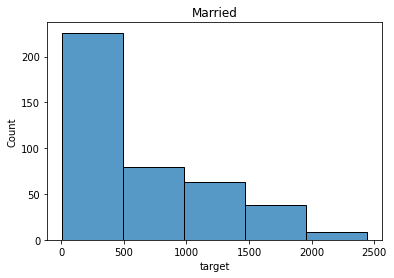

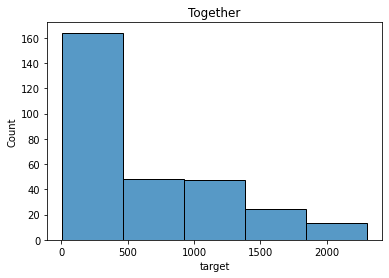

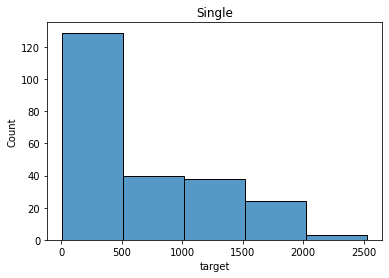

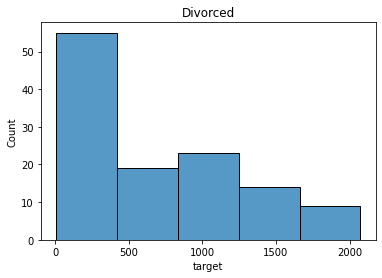

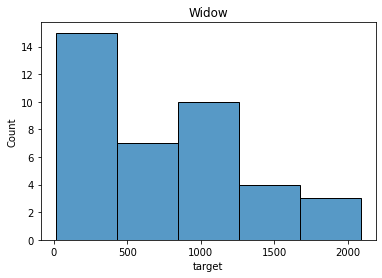

In [9]:
sns.histplot(train[train["Marital_Status"]=="Married"]["target"], bins=5)
plt.title("Married")
plt.show()
sns.histplot(train[train["Marital_Status"]=="Together"]["target"], bins=5)
plt.title("Together")
plt.show()
sns.histplot(train[train["Marital_Status"]=="Single"]["target"], bins=5)
plt.title("Single")
plt.show()
sns.histplot(train[train["Marital_Status"]=="Divorced"]["target"], bins=5)
plt.title("Divorced")
plt.show()
sns.histplot(train[train["Marital_Status"]=="Widow"]["target"], bins=5)
plt.title("Widow")
plt.show()

In [10]:
for data in [train, test]:
    for i in range(data.shape[0]):
        marital_status = data['Marital_Status'].iloc[i]
        if marital_status in ["Married", "Together"]:
            data['Marital_Status'].iloc[i] = 0
        else:
            data['Marital_Status'].iloc[i] = 1

train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day,Sign_Month
0,0,1974,Master,0,46014.0,1,1,37,21,10,...,0,0,0,0,0,541,2013,1,21,17
1,1,1962,Graduation,1,76624.0,0,1,53,68,1,...,0,0,0,0,0,899,2014,5,24,1
2,2,1951,Graduation,0,75903.0,0,1,40,50,2,...,0,0,0,0,0,901,2013,4,8,14
3,3,1974,Basic,0,18393.0,1,0,51,2,2,...,0,0,0,0,0,50,2014,3,29,3
4,4,1946,PhD,0,64014.0,2,1,54,56,7,...,0,1,0,0,0,444,2014,6,10,0


### Education

In [11]:
train["Education"].value_counts()

Graduation    570
PhD           254
Master        173
2n Cycle       89
Basic          22
Name: Education, dtype: int64

In [12]:
test["Education"].value_counts()

Graduation    546
PhD           227
Master        192
2n Cycle      111
Basic          32
Name: Education, dtype: int64

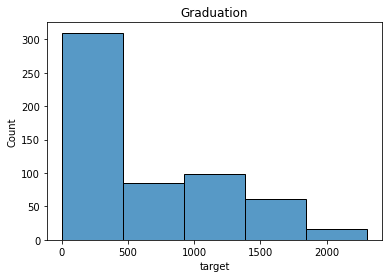

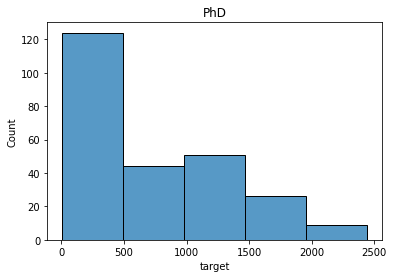

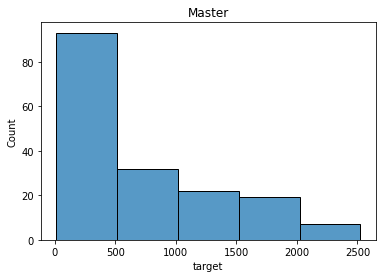

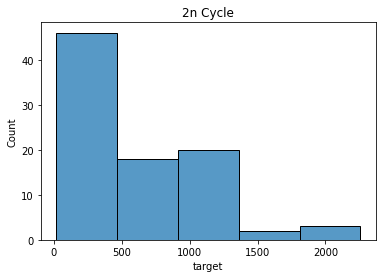

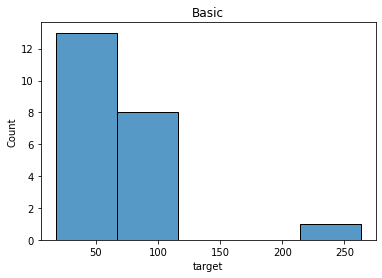

In [13]:
sns.histplot(train[train["Education"]=="Graduation"]["target"], bins=5)
plt.title("Graduation")
plt.show()
sns.histplot(train[train["Education"]=="PhD"]["target"], bins=5)
plt.title("PhD")
plt.show()
sns.histplot(train[train["Education"]=="Master"]["target"], bins=5)
plt.title("Master")
plt.show()
sns.histplot(train[train["Education"]=="2n Cycle"]["target"], bins=5)
plt.title("2n Cycle")
plt.show()
sns.histplot(train[train["Education"]=="Basic"]["target"], bins=5)
plt.title("Basic")
plt.show()

In [14]:
for data in [train, test]:
    for i in range(data.shape[0]):
        education = data['Education'].iloc[i]
        if education in ["Basic", "Graduation"]:
            data['Education'].iloc[i] = 0
        elif education in ["2n Cycle", "Master"]:
            data['Education'].iloc[i] = 1
        else:
            data['Education'].iloc[i] = 2

train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day,Sign_Month
0,0,1974,1,0,46014.0,1,1,37,21,10,...,0,0,0,0,0,541,2013,1,21,17
1,1,1962,0,1,76624.0,0,1,53,68,1,...,0,0,0,0,0,899,2014,5,24,1
2,2,1951,0,0,75903.0,0,1,40,50,2,...,0,0,0,0,0,901,2013,4,8,14
3,3,1974,0,0,18393.0,1,0,51,2,2,...,0,0,0,0,0,50,2014,3,29,3
4,4,1946,2,0,64014.0,2,1,54,56,7,...,0,1,0,0,0,444,2014,6,10,0


### New Feature

In [15]:
# Dependents
train['Dependents'] = train['Kidhome'] + train['Teenhome']
test['Dependents'] = test['Kidhome'] + test['Teenhome']

# Total Purchases
purchases_cols = [col for col in train.columns if 'Purchases' in col]
train['TotalPurchases'] = train[purchases_cols].sum(axis=1)
purchases_cols = [col for col in test.columns if 'Purchases' in col]
test['TotalPurchases'] = test[purchases_cols].sum(axis=1)

# Total Campaigns Accepted
campaigns_cols = [col for col in train.columns if 'Cmp' in col] + ['Response']
train['TotalCampaignsAcc'] = train[campaigns_cols].sum(axis=1)
campaigns_cols = [col for col in test.columns if 'Cmp' in col] + ['Response']
test['TotalCampaignsAcc'] = test[campaigns_cols].sum(axis=1)

train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,Complain,Response,target,year,month,day,Sign_Month,Dependents,TotalPurchases,TotalCampaignsAcc
0,0,1974,1,0,46014.0,1,1,37,21,10,...,0,0,541,2013,1,21,17,2,26,0
1,1,1962,0,1,76624.0,0,1,53,68,1,...,0,0,899,2014,5,24,1,1,23,1
2,2,1951,0,0,75903.0,0,1,40,50,2,...,0,0,901,2013,4,8,14,1,23,0
3,3,1974,0,0,18393.0,1,0,51,2,2,...,0,0,50,2014,3,29,3,1,8,0
4,4,1946,2,0,64014.0,2,1,54,56,7,...,0,0,444,2014,6,10,0,3,22,1


In [16]:
# # Web Event

# train["WebEvent"] = train["NumWebVisitsMonth"] + train["NumDealsPurchases"]
# test["WebEvent"] = test["NumWebVisitsMonth"] + test["NumDealsPurchases"]

# # Recency Cmp
# train["RecencyCmp"] = train["Recency"] * train["Response"]
# test["RecencyCmp"] = test["Recency"] * test["Response"]

# # Log Num Deals Purchases
# train["LogNumDealsPurchases"] = np.log1p(train["NumDealsPurchases"])
# test["LogNumDealsPurchases"] = np.log1p(test["NumDealsPurchases"])

# train.head()

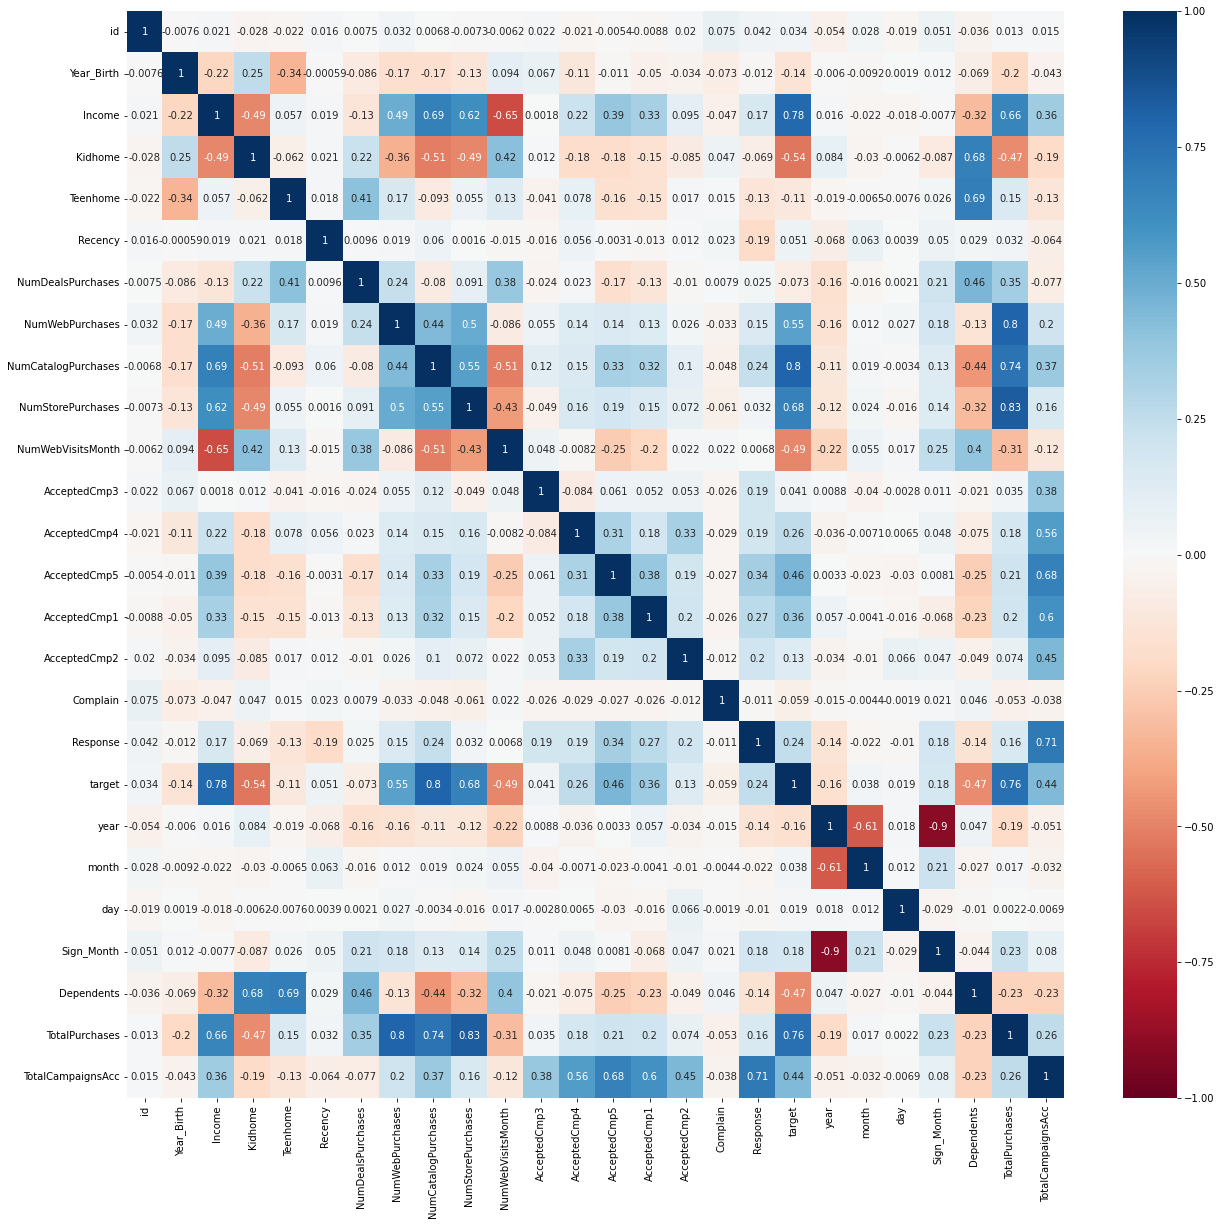

In [17]:
plt.figure(figsize=(21,20))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

In [18]:
target_corr = np.abs(train.corr()["target"]).sort_values()
target_corr

day                    0.018917
id                     0.034192
month                  0.037649
AcceptedCmp3           0.040736
Recency                0.050873
Complain               0.058704
NumDealsPurchases      0.072802
Teenhome               0.109214
AcceptedCmp2           0.129995
Year_Birth             0.136035
year                   0.159404
Sign_Month             0.176342
Response               0.242760
AcceptedCmp4           0.256784
AcceptedCmp1           0.361102
TotalCampaignsAcc      0.444114
AcceptedCmp5           0.458208
Dependents             0.471012
NumWebVisitsMonth      0.488252
Kidhome                0.538365
NumWebPurchases        0.546082
NumStorePurchases      0.677785
TotalPurchases         0.757744
Income                 0.784084
NumCatalogPurchases    0.798065
target                 1.000000
Name: target, dtype: float64

In [19]:
drop_corr = target_corr[target_corr.apply(lambda x : x < 0.1)]
drop_corr

day                  0.018917
id                   0.034192
month                0.037649
AcceptedCmp3         0.040736
Recency              0.050873
Complain             0.058704
NumDealsPurchases    0.072802
Name: target, dtype: float64

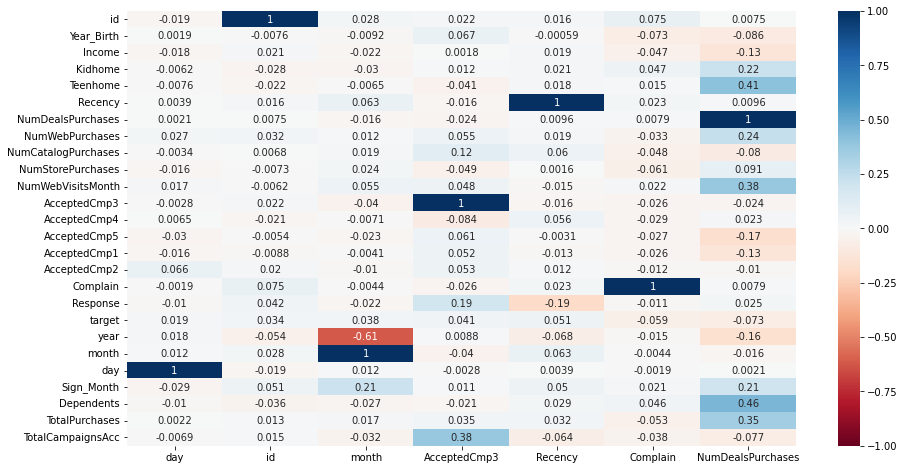

In [20]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr()[drop_corr.index], vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

In [21]:
train = train.drop(["Dt_Customer"], axis=1)
test = test.drop(["Dt_Customer"], axis=1)

train = train.drop(["id", "year", "month", "day", "Recency", "Complain"], axis=1)
test = test.drop(["id", "year", "month", "day", "Recency", "Complain"], axis=1)

train.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,target,Sign_Month,Dependents,TotalPurchases,TotalCampaignsAcc
0,1974,1,0,46014.0,1,1,10,7,1,8,...,0,0,0,0,0,541,17,2,26,0
1,1962,0,1,76624.0,0,1,1,5,10,7,...,0,0,0,0,0,899,1,1,23,1
2,1951,0,0,75903.0,0,1,2,6,6,9,...,0,0,0,0,0,901,14,1,23,0
3,1974,0,0,18393.0,1,0,2,3,0,3,...,0,0,0,0,0,50,3,1,8,0
4,1946,2,0,64014.0,2,1,7,8,2,5,...,0,0,1,0,0,444,0,3,22,1


## Training

In [22]:
## Valid

X = train.drop(["target"], axis=1)
y = train.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

## Scaler

scaler=StandardScaler().fit(X_train)
# scaler=MinMaxScaler().fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

X_train.shape, X_test.shape

((831, 22), (277, 22))

In [23]:
estimator1 = LinearRegression(n_jobs=-1)
estimator2 = Ridge(random_state=seed)
estimator3 = Lasso(random_state=seed)
estimator4 = ElasticNet(random_state=seed)
estimator5 = Lars(random_state=seed)
estimator6 = LassoLars(random_state=seed)
estimator7 = OrthogonalMatchingPursuit()
estimator8 = BayesianRidge()
estimator9 = ARDRegression()
estimator10 = PassiveAggressiveRegressor(random_state=seed)
estimator11 = RANSACRegressor(random_state=seed)
estimator12 = TheilSenRegressor(n_jobs=-1, random_state=seed)
estimator13 = HuberRegressor()
estimator14 = KernelRidge()
estimator15 = SVR()
estimator16 = KNeighborsRegressor(n_jobs=-1)
estimator17 = DecisionTreeRegressor(random_state=seed)
estimator18 = ExtraTreeRegressor(random_state=seed)
estimator19 = BaggingRegressor(n_jobs=-1, random_state=seed)
estimator20 = ExtraTreesRegressor(n_jobs=-1, random_state=seed)
estimator21 = RandomForestRegressor(n_jobs=-1, random_state=seed)
estimator22 = AdaBoostRegressor(random_state=seed)
estimator23 = GradientBoostingRegressor(random_state=seed)
estimator24 = HistGradientBoostingRegressor(random_state=seed)
estimator25 = XGBRegressor(n_jobs=-1, random_state=seed)
estimator26 = LGBMRegressor(n_jobs=-1, random_state=seed)
estimator27 = CatBoostRegressor(verbose=False, random_state=seed)
estimator28 = MLPRegressor(random_state=seed)

In [24]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

In [25]:
%%time

## model
base_ml = [
           estimator1, estimator2, estimator3, estimator4, estimator5, estimator6, estimator7,
           estimator8, estimator9, estimator10, estimator11, estimator12, estimator13, estimator14,
           estimator15, estimator16, estimator17, estimator18, estimator19, estimator20, estimator21,
           estimator22, estimator23, estimator24, estimator25, estimator26, estimator27, estimator28
           ]

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in base_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:660: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=4.137e-02, with an active set of 21 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parame

[06:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

CPU times: user 55.6 s, sys: 15.1 s, total: 1min 10s
Wall time: 1min 8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [26]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

scores={}
for idx, estimator in enumerate(base_ml):
    scores[idx]=NMAE(y_test, estimator.predict(X_test))
sorted(scores.items(), key = lambda item : item[1])

[(20, 0.18057264550116295),
 (26, 0.1813612989283264),
 (19, 0.1834797545324627),
 (23, 0.1868863760280891),
 (25, 0.18760171153735283),
 (18, 0.19460251632247036),
 (24, 0.19880111170131737),
 (22, 0.19915178214491014),
 (15, 0.2588528035419062),
 (16, 0.2671673158292936),
 (12, 0.2682867589815198),
 (17, 0.27044021632527254),
 (9, 0.2749464767784879),
 (10, 0.27867200472401105),
 (8, 0.2822270819805139),
 (2, 0.2822839560928532),
 (1, 0.282570896399886),
 (7, 0.2826338146287088),
 (0, 0.28266532940598216),
 (4, 0.2832601556149173),
 (11, 0.28921097640481325),
 (5, 0.29211382450317114),
 (3, 0.3077219160112269),
 (21, 0.3108724306129406),
 (6, 0.34914319217818657),
 (27, 0.5069263219068271),
 (14, 0.7373114721310627),
 (13, 0.970703825197544)]

In [27]:
model_idx=np.array(sorted(scores.items(), key = lambda item : item[1]))[:best_n, 0]
best_ml=[value for i, value in enumerate(base_ml) if i in model_idx]
best_ml

[ExtraTreesRegressor(n_jobs=-1, random_state=1011),
 RandomForestRegressor(n_jobs=-1, random_state=1011),
 HistGradientBoostingRegressor(random_state=1011),
 LGBMRegressor(random_state=1011),

In [28]:
meta_clf=LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction=meta_clf.predict(meta_ml_X_test)

## Valid

nmae_all=NMAE(y_test, prediction)
print("nmae_all: ", nmae_all)

wandb.log({'NMAE_all': nmae_all})

nmae_all:  0.17779741554735584


In [29]:
%%time

## model

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in best_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

CPU times: user 34.9 s, sys: 2.05 s, total: 37 s
Wall time: 24.5 s


In [30]:
meta_clf=LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction=meta_clf.predict(meta_ml_X_test)

## Valid

nmae_best=NMAE(y_test, prediction)
print("nmae_best: ", nmae_best)

wandb.log({'NMAE_best': nmae_best})

nmae_best:  0.1664836600452014


## Inference

In [31]:
## Test

X_train = train.drop(["target"], axis=1)
y_train = train.target
X_test = test

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

## Scaler

scaler=StandardScaler().fit(X_train)
# scaler=MinMaxScaler().fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

X_train.shape, X_test.shape

((1108, 22), (1108, 22))

In [32]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

In [33]:
%%time

## model

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in best_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

CPU times: user 39.6 s, sys: 2.51 s, total: 42.1 s
Wall time: 28.4 s


In [34]:
meta_clf=LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction=meta_clf.predict(meta_ml_X_test)

## Test

submission = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235893_소비자 데이터 기반 소비 예측 경진대회/data/sample_submission.csv")
submission["target"] = prediction.round()
submission.to_csv("/content/drive/MyDrive/DACON-Basic/235893_소비자 데이터 기반 소비 예측 경진대회/submission.csv",index=False)